In [1]:
import pandas as pd
from path_calc import Solver
from evaluation import Eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
source_df = pd.read_csv('panacea_sources.tsv', sep='\t')

In [3]:
net = pd.read_csv('collectri_network_sscp.sif', sep='\t')

In [4]:
G = nx.read_weighted_edgelist('collectri_network_sscp.sif', delimiter = '\t', create_using = nx.DiGraph)
for u, v, data in G.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)

In [5]:
drugs = source_df.cmpd.to_list()

In [6]:
nodes_network = [f for f in G.nodes]
filtered_source_df = source_df[source_df.target.isin(nodes_network)]

In [7]:
# create a dictionary per treatment, with the targets as keys and the sign as value
source_dict = {}
for i in range(len(filtered_source_df)):
    treatment = filtered_source_df.iloc[i, 0]
    target = filtered_source_df.iloc[i, 1]
    sign = filtered_source_df.iloc[i, 2]
    if treatment not in source_dict:
        source_dict[treatment] = {}
    source_dict[treatment][target] = float(sign)

filtered_source_df


,cmpd,target,sign
0,AEE788,LIMK1,-1
1,AFATINIB,MAPKAPK2,-1
3,BAFETINIB,MAPK14,-1
4,BOSUTINIB,STK10,-1
5,CABOZANTINIB,ABL2,-1
6,CEDIRANIB,DDR2,-1
7,CRENOLANIB,CDK9,-1
8,CRIZOTINIB,PRKD3,-1
9,DACOMITINIB,RIPK2,-1
10,DASATINIB,LIMK2,-1


In [8]:
drugs = filtered_source_df.cmpd.to_list()

In [9]:
targets = pd.read_csv('panacea_targets.tsv', sep='\t')
targets

,gene_symbol,cell_line,treatment,logFC,padj,stat
0,TXNDC17,HSTS,AEE788,1.734704,2.700272e-11,7.775353
1,RDH11,KRJ1,AEE788,1.716373,1.337847e-04,5.548719
2,CWC22,ASPC,AEE788,1.990607,1.863559e-03,4.833195
3,MYC,LNCAP,AEE788,2.396950,1.931015e-03,4.449534
4,RPS2,H1793,AEE788,1.709342,1.071796e-02,4.227241
...,...,...,...,...,...,...
3934,SPTSSA,U87,VARLITINIB,2.059202,4.369749e-02,3.285614
3935,PFN1,U87,VARLITINIB,3.486074,4.488885e-02,3.274220
3936,BUD13,U87,VARLITINIB,3.114187,4.488885e-02,3.269581
3937,OXNAD1,U87,VARLITINIB,2.872608,4.488885e-02,3.268999


In [14]:
cell_lines = targets.cell_line.unique().tolist()
cell_lines

['HSTS',
 'KRJ1',
 'ASPC',
 'LNCAP',
 'H1793',
 'PANC1',
 'EFO21',
 'DU145',
 'HF2597',
 'U87',
 'HCC1143']

In [34]:
agg_targets_filtered

,gene_symbol,cell_line,treatment,logFC,padj,stat
0,PTPRF,HCC1143,BAFETINIB,1.720528,0.001300,5.309043
1,DPYSL2,HCC1143,BAFETINIB,4.925472,0.006066,4.886086
2,SLC1A5,HCC1143,BAFETINIB,1.504623,0.013509,4.642879
3,GSK3B,HCC1143,BOSUTINIB,1.554388,0.011422,4.665658
4,SLC39A6,HCC1143,BOSUTINIB,2.455639,0.011422,4.497133
...,...,...,...,...,...,...
201,RPL18A,HCC1143,VANDETANIB,6.812208,0.042616,3.293488
202,ERI1,HCC1143,VANDETANIB,5.339066,0.046223,3.260919
203,SMIM3,HCC1143,VANDETANIB,3.793819,0.047090,3.252915
204,RPS26,HCC1143,VARLITINIB,21.645265,0.002501,5.188635


In [36]:
for cell_line in cell_lines:
    # filter targets per cell line
    agg_targets = targets[targets['cell_line'] == cell_line]
    agg_targets.sort_values(by=['treatment'], inplace=True)
    # per treatment, get a max of 100 targets, sorted by largest absolute value of stat column
    agg_targets_filtered = agg_targets.groupby(by=['treatment']).apply(lambda x: x.sort_values(by=['stat'], ascending=False).head(100)).reset_index(drop=True)
    # create a dictionary per treatment, with the targets as keys and a +1 or -1 depending of the sign of the stat column
    target_dict[cell_line] = {}
    for treatment in agg_targets_filtered.treatment.unique():
        target_dict[cell_line][treatment] = {}
        for index, row in agg_targets_filtered[agg_targets_filtered.treatment == treatment].iterrows():
            target_dict[cell_line][treatment][row['gene_symbol']] = row['stat'] / abs(row['stat'])

target_dict

/tmp/ipykernel_1419/2828480050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)
/tmp/ipykernel_1419/2828480050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)
/tmp/ipykernel_1419/2828480050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)
/tmp/ipykernel_1419/28

{'HSTS': {'AEE788': {'TXNDC17': 1.0},
  'AFATINIB': {'SPAST': 1.0, 'VIRMA': 1.0, 'ZNF609': 1.0, 'JAK1': 1.0},
  'BAFETINIB': {'EMC6': 1.0, 'MRPS22': 1.0, 'USP36': 1.0},
  'CABOZANTINIB': {'HMGN2': 1.0,
   'HNRNPAB': 1.0,
   'IWS1': 1.0,
   'TTC3': 1.0,
   'RSRC1': 1.0,
   'POLD3': 1.0,
   'KIF21A': 1.0,
   'INO80': 1.0,
   'MAP4K4': 1.0,
   'BRD3': 1.0,
   'CDCA2': 1.0},
  'CEDIRANIB': {'RPL21P28': 1.0},
  'CRENOLANIB': {'BRD8': 1.0,
   'BAZ1B': 1.0,
   'DDX3Y': 1.0,
   'FSD1L': 1.0,
   'BRD3': 1.0,
   'NAA20': 1.0},
  'DACOMITINIB': {'SRSF3': 1.0,
   'EIF3A': 1.0,
   'MYCBP2': 1.0,
   'RAPGEF1': 1.0,
   'XPC': 1.0},
  'DASATINIB': {'EEF2': 1.0,
   'PAWR': 1.0,
   'POLD3': 1.0,
   'HSPA9': 1.0,
   'TIFA': 1.0},
  'FORETINIB': {'KPNA4': 1.0},
  'GEFITINIB': {'TRMT5': 1.0,
   'CYCS': 1.0,
   'SLC2A5': 1.0,
   'ELP1': 1.0,
   'PAXBP1': 1.0,
   'BTN2A1': 1.0,
   'GCHFR': 1.0,
   'DNASE1L3': 1.0,
   'HS2ST1': 1.0},
  'ICOTINIB': {'TAF15': 1.0, 'SH3BP5': 1.0, 'DPF2': 1.0, 'RPS6KA3': 1.0},
  

In [23]:
for cell_line in cell_lines:
    # filter targets per cell line
    agg_targets = targets[targets['cell_line'] == cell_line]
    agg_targets.sort_values(by=['treatment'], inplace=True)
    # per treatment, get a max of 100 targets, sorted by largest absolute value of stat column
    agg_targets_filtered = agg_targets.groupby(by=['treatment']).apply(lambda x: x.sort_values(by=['stat'], ascending=False).head(100)).reset_index(drop=True)
    # create a dictionary per treatment, with the targets as keys and a +1 or -1 depending of the sign of the stat column
    target_dict = {}
    for treatment in agg_targets_filtered.treatment.unique():
        target_dict[treatment] = {}
        for index, row in agg_targets_filtered[agg_targets_filtered.treatment == treatment].iterrows():
            target_dict[treatment][row['gene_symbol']] = row['stat'] / abs(row['stat'])

    target_dict

    # remove those drugs from the target_dict that have below 5 targets
    target_dict_filtered = {}
    for treatment in target_dict:
        if len(target_dict[treatment]) >= 5:
            target_dict_filtered[treatment] = target_dict[treatment]
    
    selected_drugs = list(set(target_dict_filtered.keys()).intersection(set(source_dict.keys())))

    for drug in selected_drugs:
        print('Solving for cell line {} and drug {}'.format(cell_line, drug))    
        G_solver = Solver(G, 'PANACEA')
        G_solver.source_dict = source_dict[drug]
        G_solver.target_dict = target_dict_filtered[drug]
        G_solver.network_batchrun(iter = f'{cell_line}_{drug}', cutoff = 4)


/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line HSTS and drug REGORAFENIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.005
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.004
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.003
There were no sign consistent pat

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line KRJ1 and drug VANDETANIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.0

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line ASPC and drug REGORAFENIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturbat

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line LNCAP and drug REGORAFENIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line H1793 and drug OSIMERTINIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturba

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign 

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line EFO21 and drug KW2449
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturbations

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line DU145 and drug REGORAFENIB
Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.008
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.007
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.006
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
There were no sign consistent paths for the given perturbat

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Computing path 1 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
There were no sign consistent paths for the given perturbations and downstream effects.
There were no sign consistent paths for the given perturbations and downstream effects.
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Comput

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Solving for cell line U87 and drug VANDETANIB
Computing path 1 with threshold 0.01
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Computing path 2 with threshold 0.004
Computing path 2 with threshold 0.003
Computing path 2 with threshold 0.002
Computing path 2 with threshold 0.001
The graph is too large to visualize. It has 678 edges.
Solving for cell line U87 and drug OSIMERTINIB
Computing path 1 with threshold 0.01
There were no sign co

/tmp/ipykernel_668/4055217462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_targets.sort_values(by=['treatment'], inplace=True)


Computing path 1 with threshold 0.01
Computing path 1 with threshold 0.009
Computing path 1 with threshold 0.008
Computing path 1 with threshold 0.007
Computing path 1 with threshold 0.006
Computing path 1 with threshold 0.005
Computing path 1 with threshold 0.004
Computing path 1 with threshold 0.003
Computing path 1 with threshold 0.002
Computing path 1 with threshold 0.001
Computing path 1 with threshold 0.0
Computing path 2 with threshold 0.01
Computing path 2 with threshold 0.009
Computing path 2 with threshold 0.008
Computing path 2 with threshold 0.007
Computing path 2 with threshold 0.006
Computing path 2 with threshold 0.005
Computing path 2 with threshold 0.004
Computing path 2 with threshold 0.003
Computing path 2 with threshold 0.002
The graph is too large to visualize. It has 819 edges.
Computing path 2 with threshold 0.001
The graph is too large to visualize. It has 1647 edges.
The graph is too large to visualize. It has 1112 edges.
Solving for cell line HCC1143 and drug 

In [37]:
import pandas as pd
import os
import networkx as nx
import ptitprince as pt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class Eval:
    def __init__(self, dirpath, study_id):
        self.dirpath = dirpath
        self.G = None
        self.study_id = study_id
        self.target_dict = None
        self.tests_dict = self.get_test_dict()
        self.graphs, self.graphdata_df = self.parse_sif_files()
        self.distance_df = None
        self.filtered_df = None

    def get_datafiles(self):
        files_list = os.listdir(self.dirpath)
        sif_files = [os.path.join(self.dirpath, f) for f in files_list if (f.endswith('.sif') and (self.study_id in f))]
        return sif_files
    
    def get_test_dict(self):
        filename = f'./{self.study_id}__testtargets.csv'
        try:
            df = pd.read_csv(filename, index_col=0)
            data_dict = df.to_dict()
            for key in data_dict:
                data_dict[key] = {k: v for k, v in data_dict[key].items() if pd.notna(v)}
            
            return data_dict
        
        except FileNotFoundError:
            
            return f"File {filename} not found."

    def parse_sif_files(self):
        """
        Parse a list of SIF files, return a dictionary of networkx graphs, and extract metadata with ordered methods.
        
        Parameters:
        - file_paths (list): List of paths to the SIF files.
        
        Returns:
        - dict: Dictionary where keys are filenames (without .sif extension) and values are networkx graphs.
        - DataFrame: Metadata dataframe with study ID, methods, pagerank threshold, and original graph ID columns.
        """
        graphs = {}
        
        # Lists to store the metadata
        graph_ids = []
        study_ids = []
        iter_ids = []
        methods_list = []
        pagerank_thresholds = []

        file_paths = self.get_datafiles()
        
        for file_path in file_paths:
            # Extract the filename without the .sif extension
            graph_id = file_path.split('/')[-1].replace('.sif', '')
            
            # Store the original graph ID
            graph_ids.append(graph_id)
            
            # Initialize a directed graph
            G = nx.DiGraph()
            
            # Parse the SIF file, skipping the header
            with open(file_path, 'r') as f:
                lines = f.readlines()[1:]  # skip the header
                for line in lines:
                    parts = line.strip().split('\t')
                    if len(parts) == 3:
                        source, interaction, target = parts
                        interaction = 1 if interaction == 'P' else (-1 if interaction == 'N' else interaction)
                        G.add_edge(source, target, interaction=interaction)
            
            # Store the graph in the dictionary
            graphs[graph_id] = G
            
            # Metadata extraction
            parts = graph_id.split('__')
            study_ids.append(parts[0])
            iter_ids.append(parts[1])
            
            method_parts = parts[2:]
            pagerank_value = None
            for idx, part in enumerate(method_parts):
                if "pagerank" in part:
                    pagerank_value = float(part.split('_')[-1])  # Extract float value after "pagerank_"
                    method_parts[idx] = "pagerank"  # Replace with "pagerank" string
            
            pagerank_thresholds.append(pagerank_value)
            methods_list.append(', '.join(method_parts))
        
        # Create the metadata dataframe
        metadata_df = pd.DataFrame({
            'Graph ID': graph_ids,
            'Study ID': study_ids,
            'Iteration': iter_ids,
            'Methods': methods_list,
            'Pagerank Threshold': pagerank_thresholds
        })

        metadata_df.sort_values(by=['Study ID', 'Iteration', 'Methods', 'Pagerank Threshold'], inplace=True)
        
        return graphs, metadata_df
    

    # Distance eval
    def distance_calc(self):
        distances = []
        test_nodes = []
        network_nodes = []
        graph_ids = []
        run_ids = []
        undirG = self.G.reverse()
        for graph in self.graphs:
            run = graph.strip().split('__')[1]
            nodes_subnetwork = [node for node in self.graphs[graph].nodes]
            for node in nodes_subnetwork:
                for test_node in self.tests_dict[run]:
                    try:
                        distance = nx.shortest_path_length(undirG, source=test_node, target=node)
                    except nx.NetworkXNoPath:
                        distance = np.Inf
                    distances.append(distance)
                    test_nodes.append(test_node)
                    network_nodes.append(node)
                    graph_ids.append(graph)
                    run_ids.append(run)
        
        self.distance_df = pd.DataFrame({
            'Graph ID': graph_ids,
            'Run ID': run_ids,
            'Study ID': self.study_id,
            'Test nodes': test_nodes,
            'Network nodes': network_nodes,
            'Distances': distances
        })

        self.plot_distance(self.distance_df)
        
        return self.distance_df
    
    def plot_distance(self, distances_df):
        distances_df["Main Method"] = distances_df["Graph ID"].apply(lambda x: x.split("__")[2].split('_pagerank')[0])
        plt.figure(figsize=(15, 10))
        
        # Creating a color palette for pagerank thresholds
        unique_thresholds = distances_df["Graph ID"].apply(lambda x: x.split('_')[-1]).unique()
        color_palette = dict(zip(unique_thresholds, sns.color_palette("rainbow", len(unique_thresholds))))
        
        # Boxplot
        sns.boxplot(data=distances_df, x="Main Method", y="Distances", hue="Graph ID", palette=color_palette, dodge=True)
        
        # Adjusting the plot aesthetics
        plt.xticks(rotation=45)
        plt.legend(title="Pagerank Threshold", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        
        plt.show()

    # Comparisons
    def get_number_nodes(self):
        """
        For a given dictionary of networks, computes the number of nodes and appends it to the self.graphdata_df dataframe.
        """
        num_nodes = []
        for graph in self.graphs:
            num_nodes.append(len(self.graphs[graph].nodes))
        nodes_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Number of nodes': num_nodes})
        self.graphdata_df = pd.merge(self.graphdata_df, nodes_info, on="Graph ID")
    
    def get_number_edges(self):
        num_edges = []
        for graph in self.graphs:
            num_edges.append(len(self.graphs[graph].edges))
        edges_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Number of edges': num_edges})
        self.graphdata_df = pd.merge(self.graphdata_df, edges_info, on="Graph ID")

    def get_connected_targets(self, target_dict):
        """
        Given a network and a set of targets, compute how many targets are in the network (nodes)
        """
        num_targets = []
        for graph in self.graphs:
            iter_id = graph.split('__')[1]
            cell_line = iter_id.split('_')[0]
            drug = iter_id.split('_')[1]
            targets = target_dict[cell_line][drug].keys()
            num_targets.append(len(set(targets) & set(self.graphs[graph].nodes)))
        targets_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Connected targets': num_targets})
        self.graphdata_df = pd.merge(self.graphdata_df, targets_info, on="Graph ID")

    def compute_degree_distribution(self):
        """
        Compute the degree distribution for each graph in the self.graphs dictionary.
        """
        degree_distributions = []
        for graph in self.graphs:
            degree_distributions.append(self.graphs[graph].degree)
        degree_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Degree distribution': degree_distributions})
        self.graphdata_df = pd.merge(self.graphdata_df, degree_info, on="Graph ID")

    def find_elbow(self, x, y):
        """
        Find the elbow of a curve using x and y coordinates.

        Args:
            x (list): List of x coordinates.
            y (list): List of y coordinates.

        Returns:
            int: Index of the elbow point.
        """
        # Coordinates of the first point
        p1 = np.array([x[0], y[0]])
        
        # Coordinates of the last point
        p2 = np.array([x[-1], y[-1]])
        
        
        # Find the elbow by computing distance from each point to the line
        distances = []
        for i in range(len(x)):
            point = np.array([x[i], y[i]])
            distance = np.linalg.norm(np.cross(p2-p1, p1-point))/np.linalg.norm(p2-p1)
            distances.append(distance)
            
        # Return the index of the point with max distance which is the elbow
        return np.argmax(distances)
    
    def threshold_filter(self):
        perc_missing_targets = []
        num_edges = []

        methods = set(self.graphdata_df['Methods'].tolist())
        iterations = set(self.graphdata_df['Iteration'].tolist())
        filtered_df = pd.DataFrame()

        for iterat in iterations:
            for method in methods:
                drug = iterat.split('_')[1]
                cell_line = iterat.split('_')[0]
                print(f"Processing {method} {iterat}...")
                sorted_df = self.graphdata_df[(self.graphdata_df['Methods'] == method) & (self.graphdata_df['Iteration'] == iterat)].sort_values(by=['Pagerank Threshold'])

                targets = self.target_dict[cell_line][drug].keys()
                num_targets = len(targets)
                # add column of missing targets
                sorted_df['Perc missing targets'] = (num_targets - sorted_df['Connected targets']) / num_targets * 100

                perc_missing_targets = sorted_df['Perc missing targets'].tolist()
                num_edges = sorted_df['Number of edges'].tolist()
                
                selected_threshold_index = self.find_elbow(num_edges, perc_missing_targets)
                # bind rows the selected threshold to the filtered df using pd.concat
                filtered_df = pd.concat([filtered_df, sorted_df.iloc[selected_threshold_index:selected_threshold_index+1, :]])
        
        return filtered_df
   





In [38]:
G1_eval = Eval('./results/', 'PANACEA')
G1_eval.target_dict = target_dict


In [39]:
G1_eval.graphdata_df.head(40)

,Graph ID,Study ID,Iteration,Methods,Pagerank Threshold
1650,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.001
191,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.002
3252,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.003
283,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.004
1179,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.005
2052,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.006
1177,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.007
3265,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.008
355,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.009
2734,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.010


In [40]:
G1_eval.get_number_nodes()

In [41]:
G1_eval.get_number_edges()

In [42]:
G1_eval.compute_degree_distribution()

In [43]:
target_dict.keys()

dict_keys(['HSTS', 'KRJ1', 'ASPC', 'LNCAP', 'H1793', 'PANC1', 'EFO21', 'DU145', 'HF2597', 'U87', 'HCC1143'])

In [50]:
G1_eval.get_connected_targets(target_dict)

In [51]:
G1_eval.graphdata_df

,Graph ID,Study ID,Iteration,Methods,Pagerank Threshold,Number of nodes,Number of edges,Degree distribution,Connected targets_x,Connected targets_y
0,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.001,89,271,"((MAPKAPK2, 6), (MAPK14, 18), (GADD45A, 2), (M...",2,2
1,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.002,54,156,"((MAPKAPK2, 5), (MAPK14, 13), (GADD45A, 2), (M...",2,2
2,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.003,26,78,"((MAPKAPK2, 5), (MAPK14, 12), (TP53, 7), (ESR1...",1,1
3,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.004,19,47,"((MAPKAPK2, 3), (MAPK1, 10), (TP53, 5), (ESR1,...",1,1
4,PANACEA__ASPC_AFATINIB__reachability__pagerank...,PANACEA,ASPC_AFATINIB,"reachability, pagerank, reachability, allpaths",0.005,14,23,"((MAPKAPK2, 2), (AR, 10), (NFKB1, 2), (ESR1, 1...",1,1
...,...,...,...,...,...,...,...,...,...,...
3691,PANACEA__U87_VARLITINIB__reachability__pageran...,PANACEA,U87_VARLITINIB,"reachability, pagerank, shortest, sc",0.006,6,7,"((RIPK2, 2), (NFKB1, 2), (TP53, 3), (PLK1, 2),...",1,1
3692,PANACEA__U87_VARLITINIB__reachability__pageran...,PANACEA,U87_VARLITINIB,"reachability, pagerank, shortest, sc",0.007,0,0,(),0,0
3693,PANACEA__U87_VARLITINIB__reachability__pageran...,PANACEA,U87_VARLITINIB,"reachability, pagerank, shortest, sc",0.008,0,0,(),0,0
3694,PANACEA__U87_VARLITINIB__reachability__pageran...,PANACEA,U87_VARLITINIB,"reachability, pagerank, shortest, sc",0.009,0,0,(),0,0


In [52]:
filtered_rundf = G1_eval.threshold_filter()

Processing reachability, pagerank, reachability, allpaths H1793_VARLITINIB...


KeyError: 'H1793_VARLITINIB'

In [25]:
filtered_rundf

,Graph ID,Study ID,Iteration,Methods,Pagerank Threshold,Number of nodes,Number of edges,Degree distribution,Connected targets,Perc missing targets
694,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, shortest",0.002,19,24,"((CLK2, 1), (AKT1, 12), (PIK3R1, 2), (PTK2, 4)...",6,94.000000
704,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, shortest, sc",0.001,6,7,"((CLK2, 1), (AKT1, 4), (MYC, 2), (MAZ, 3), (SP...",1,99.000000
683,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, reachability, allpaths...",0.002,60,172,"((CLK2, 2), (GLI2, 8), (PRKACA, 5), (AKT1, 37)...",4,96.000000
673,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, reachability, allpaths",0.002,68,311,"((CLK2, 2), (AKT1, 43), (PIK3R1, 15), (PTK2, 5...",6,94.000000
611,PANACEA__PONATINIB__reachability__pagerank_0.0...,PANACEA,PONATINIB,"reachability, pagerank, shortest",0.003,28,44,"((MAP4K1, 2), (ABL1, 6), (TP53, 6), (GRK5, 1),...",9,91.000000
...,...,...,...,...,...,...,...,...,...,...
422,PANACEA__MK2206__reachability__pagerank_0.003_...,PANACEA,MK2206,"reachability, pagerank, reachability, allpaths",0.003,24,43,"((AKT3, 1), (MTOR, 5), (CHUK, 9), (TP53, 3), (...",3,86.363636
359,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, shortest",0.003,4,3,"((FLT3, 1), (STAT3, 2), (MAPK14, 2), (GADD45A,...",1,91.666667
368,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, shortest, sc",0.001,4,3,"((FLT3, 1), (STAT3, 2), (MAPK14, 2), (GADD45A,...",1,91.666667
348,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, reachability, allpaths...",0.003,14,25,"((FLT3, 3), (STAT3, 6), (MAPK14, 10), (GADD45A...",1,91.666667


In [30]:
filtered_rundf.to_csv('panacea_filtered_runresults.tsv', sep='\t', index=False)

In [26]:
#get row with minimum percentage of missing targets
min_missing = filtered_rundf[filtered_rundf['Perc missing targets'] == filtered_rundf['Perc missing targets'].min()]
min_missing

,Graph ID,Study ID,Iteration,Methods,Pagerank Threshold,Number of nodes,Number of edges,Degree distribution,Connected targets,Perc missing targets
272,PANACEA__KW2449__reachability__pagerank_0.0__s...,PANACEA,KW2449,"reachability, pagerank, shortest",0.0,111,215,"((MAP4K2, 1), (TRAF2, 25), (E2F1, 19), (CTNNB1...",19,70.769231


In [31]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from PyComplexHeatmap import *

# Load the data
df = pd.read_csv('panacea_filtered_runresults.tsv', sep='\t')

# Function to calculate the median degree
def calculate_mean_degree(degree_dist_str):
    try:
        degree_dist = ast.literal_eval(degree_dist_str)
        if not degree_dist:
            return None
        degrees = [degree for _, degree in degree_dist]
        degrees.sort()
        n = len(degrees)
        return np.mean(degrees)
    except Exception as e:
        return None

# Calculate the median degree
df['Mean degree'] = df['Degree distribution'].apply(calculate_mean_degree)

def calculate_relative_mean_degree(row):
    try:
        N = row['Number of nodes']
        median_degree = row['Mean degree']
        max_degree = 2 * (N - 1)
        
        if max_degree == 0:  # Handling the case where the network has only one node
            return None
        
        relative_median_degree = median_degree / max_degree
        return relative_median_degree
    except Exception as e:
        return None

df['Relative Median degree'] = df.apply(calculate_relative_mean_degree, axis=1)
df

,Graph ID,Study ID,Iteration,Methods,Pagerank Threshold,Number of nodes,Number of edges,Degree distribution,Connected targets,Perc missing targets,Mean degree,Relative Median degree
0,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, shortest",0.002,19,24,"[('CLK2', 1), ('AKT1', 12), ('PIK3R1', 2), ('P...",6,94.000000,2.526316,0.070175
1,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, shortest, sc",0.001,6,7,"[('CLK2', 1), ('AKT1', 4), ('MYC', 2), ('MAZ',...",1,99.000000,2.333333,0.233333
2,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, reachability, allpaths...",0.002,60,172,"[('CLK2', 2), ('GLI2', 8), ('PRKACA', 5), ('AK...",4,96.000000,5.733333,0.048588
3,PANACEA__SUNITINIB__reachability__pagerank_0.0...,PANACEA,SUNITINIB,"reachability, pagerank, reachability, allpaths",0.002,68,311,"[('CLK2', 2), ('AKT1', 43), ('PIK3R1', 15), ('...",6,94.000000,9.147059,0.068262
4,PANACEA__PONATINIB__reachability__pagerank_0.0...,PANACEA,PONATINIB,"reachability, pagerank, shortest",0.003,28,44,"[('MAP4K1', 2), ('ABL1', 6), ('TP53', 6), ('GR...",9,91.000000,3.142857,0.058201
...,...,...,...,...,...,...,...,...,...,...,...,...
71,PANACEA__MK2206__reachability__pagerank_0.003_...,PANACEA,MK2206,"reachability, pagerank, reachability, allpaths",0.003,24,43,"[('AKT3', 1), ('MTOR', 5), ('CHUK', 9), ('TP53...",3,86.363636,3.583333,0.077899
72,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, shortest",0.003,4,3,"[('FLT3', 1), ('STAT3', 2), ('MAPK14', 2), ('G...",1,91.666667,1.500000,0.250000
73,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, shortest, sc",0.001,4,3,"[('FLT3', 1), ('STAT3', 2), ('MAPK14', 2), ('G...",1,91.666667,1.500000,0.250000
74,PANACEA__LINIFANIB__reachability__pagerank_0.0...,PANACEA,LINIFANIB,"reachability, pagerank, reachability, allpaths...",0.003,14,25,"[('FLT3', 3), ('STAT3', 6), ('MAPK14', 10), ('...",1,91.666667,3.571429,0.137363


In [54]:
metrics = ['Number of nodes', 'Number of edges', 'Relative Median degree', 'Perc missing targets']
for metric in metrics:
    df[f'Method_{metric}'] = df['Methods'] + '_' + metric

# Melting the DataFrame to have one row for each combination of iteration, method, and metric
df_melted = df.melt(id_vars=['Iteration', 'Methods'], value_vars=metrics, 
                    var_name='Metric', value_name='Value')

# Creating a new column that combines the method and metric
df_melted['Method_Metric'] = df_melted['Methods'] + '_' + df_melted['Metric']

# Pivoting the DataFrame to have iterations as rows and Method_Metric as columns
df_wide = df_melted.pivot_table(index='Iteration', columns='Method_Metric', values='Value')
df_wide

# change NaN to 0
df_wide.fillna(0, inplace=True)


In [55]:
# subset the df_melted to include only the columns Methods Metric and Method_metric
df_melted_subset = df_melted[['Methods', 'Metric', 'Method_Metric']]
# mode the method_metric column to index
df_melted_subset.set_index('Method_Metric', inplace=True)

/home/victo/miniconda3/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:812: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/victo/miniconda3/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:812: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/victo/miniconda3/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:812: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/victo/miniconda3/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:812: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


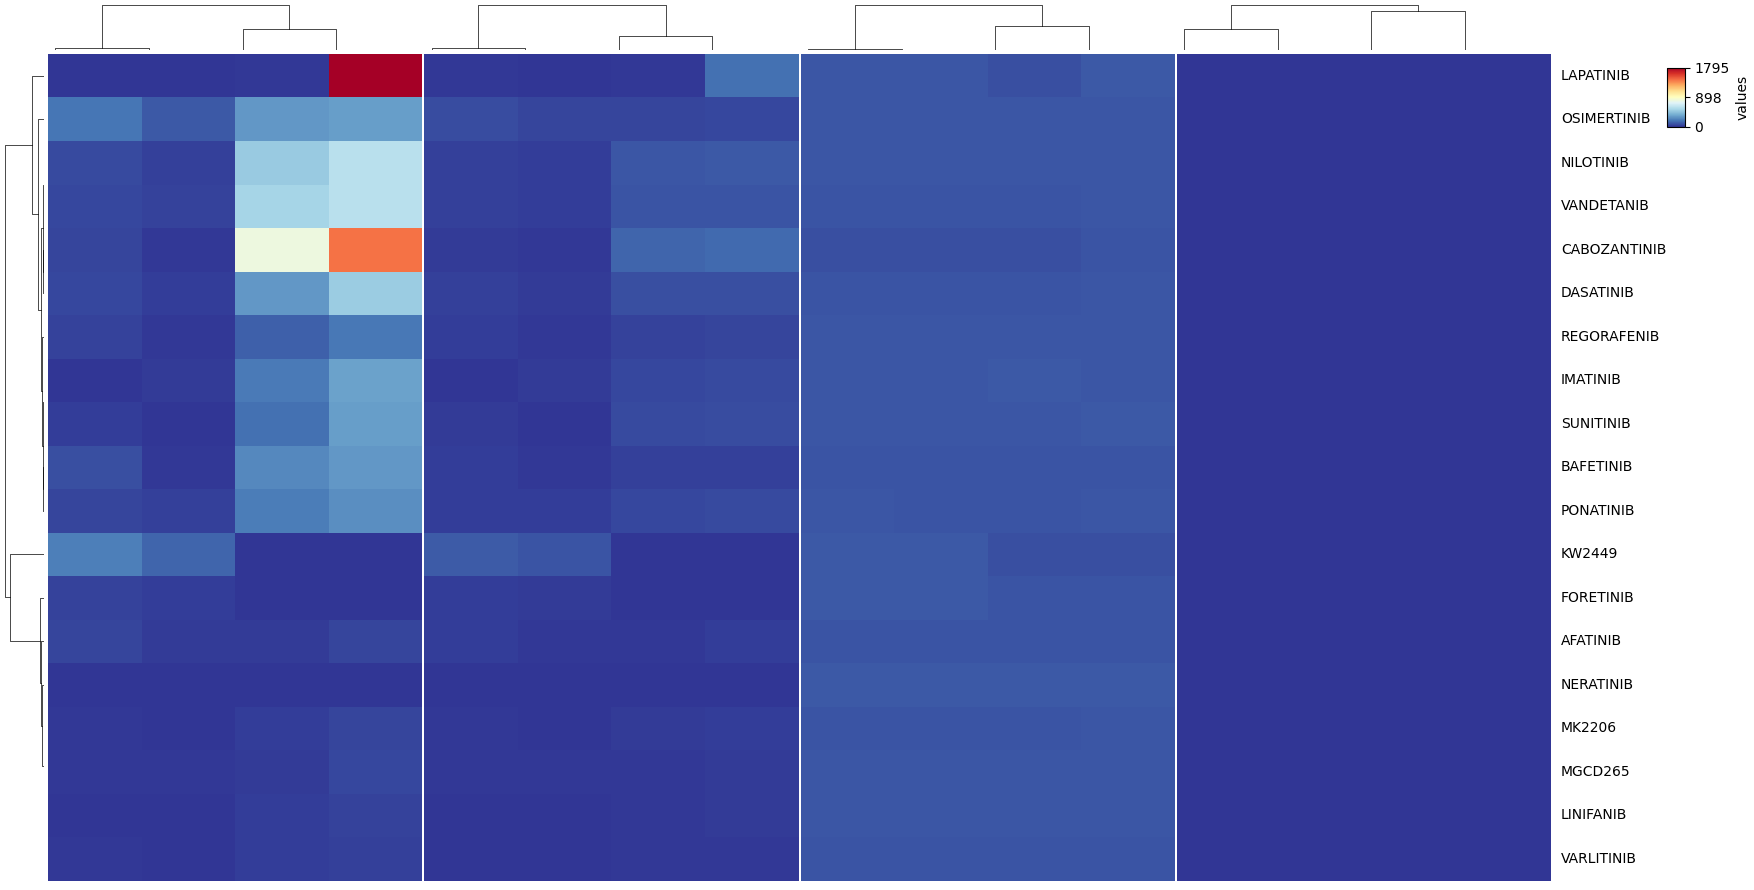

In [57]:

plt.figure(figsize=(20, 10))
cm = ClusterMapPlotter(data=df_wide,
                       col_cluster=True,row_cluster=True,
                       col_split=df_melted_subset.Metric,
                       col_split_gap=0.5,
                       label='values',row_dendrogram=True,
                       col_dendrogram=True,
                       show_rownames=True,show_colnames=False,
                       tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.savefig("example0.pdf", bbox_inches='tight')
plt.show()

In [25]:
# Function to create a matrix from a column of the DataFrame
def create_matrix(column_name):
    matrix = np.empty((len(iterations), len(methods)))
    matrix[:] = np.nan  
    for i, iteration in enumerate(iterations):
        for j, method in enumerate(methods):
            value = df[(df['Iteration'] == iteration) & (df['Methods'] == method)][column_name].values
            if value.size > 0:
                matrix[i, j] = value[0]
    return matrix

# Getting unique iterations and methods
iterations = df['Iteration'].unique()
methods = df['Methods'].unique()

# Creating matrices for each data type
nodes_matrix = create_matrix('Number of nodes')
edges_matrix = create_matrix('Number of edges')
mean_degree_matrix = create_matrix('Mean degree')
perc_missing_targets_matrix = create_matrix('Perc missing targets')

nodes_matrix

array([[ 19.,   6.,  60.,  68.],
       [ 28.,  23.,  56.,  58.],
       [  8.,   8.,  10.,  19.],
       [ 23.,   8.,  42.,  46.],
       [ 24.,  14.,  14.,  24.],
       [  6.,   6.,  12.,  13.],
       [ 20.,   9., 139., 149.],
       [111.,  87.,   0.,   0.],
       [ 31.,  26.,  91.,  91.],
       [ 28.,  10.,  33.,  35.],
       [  0.,   0.,   0.,   0.],
       [ 66.,  49.,  49.,  54.],
       [ 32.,  21.,  71.,  76.],
       [ 26.,  19.,   0.,   0.],
       [  3.,  15.,  54.,  58.],
       [ 30.,  22.,  93., 102.],
       [  8.,   0.,   8., 170.],
       [ 10.,   5.,  18.,  24.],
       [  4.,   4.,  14.,  19.]])